<a href="https://colab.research.google.com/github/Frostbite22/learning-DL-by-doing-2/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import torch
from torch import nn

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data preprocessing

In [38]:
from google.colab import drive

drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/PyTorch/learning_DL2/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import zipfile
from pathlib import Path

data_path = Path('/data')
image_path = data_path / "images"

if image_path.is_dir():
  print(f'{image_path} directory already exists')
else:
  print(f"{image_path} doesn't exist, creating one ...")
  image_path.mkdir(parents=True,exist_ok=True)

with zipfile.ZipFile('hymenoptera_data.zip','r') as zip_ref:
  zip_ref.extractall(image_path)

/data/images directory already exists


In [40]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


In [41]:
walk_through_dir(image_path)

There are 1 directories and 0 images in /data/images
There are 2 directories and 0 images in /data/images/hymenoptera_data
There are 2 directories and 0 images in /data/images/hymenoptera_data/train
There are 0 directories and 121 images in /data/images/hymenoptera_data/train/bees
There are 0 directories and 124 images in /data/images/hymenoptera_data/train/ants
There are 2 directories and 0 images in /data/images/hymenoptera_data/val
There are 0 directories and 83 images in /data/images/hymenoptera_data/val/bees
There are 0 directories and 70 images in /data/images/hymenoptera_data/val/ants


In [42]:
os.getcwd()

'/content/drive/MyDrive/PyTorch/learning_DL2'

In [43]:
train_dir = image_path / "hymenoptera_data/train"
val_dir = image_path / "hymenoptera_data/val"


random img path: /data/images/hymenoptera_data/val/ants/319494379_648fb5a1c6.jpg
image class : ants
Image height: 500
image width: 474


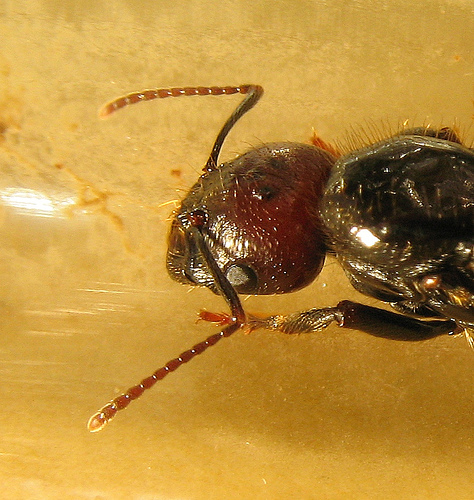

In [44]:
#Visualizing an image  
import random 
from PIL import Image 

# set seed 
random.seed(42)

#1. get all image paths 
image_path_list = list(image_path.glob("*/*/*/*.jpg"))
#2. pick a random image path 
random_image_path = random.choice(image_path_list)
#3. get image class from the path name(is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
#4. open image 
img = Image.open(random_image_path)
#5. print metadata 
print(f"random img path: {random_image_path}")
print(f"image class : {image_class}")
print(f"Image height: {img.height}")
print(f"image width: {img.width}")
img

Text(0.5, 1.0, 'image class : ants | Image Shape : (500, 474, 3) -> [height,width,color_channels]')

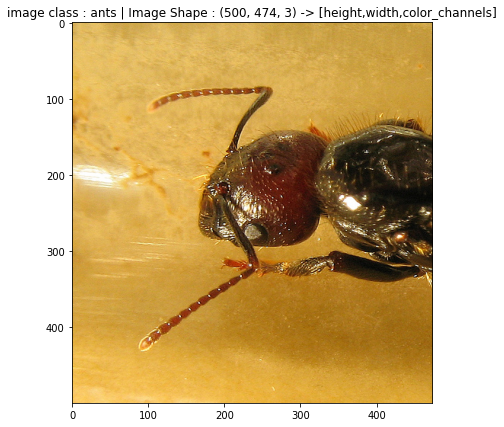

In [45]:
import numpy as np 
import matplotlib.pyplot as plt 

#Turn image to an array 
image_as_array = np.asarray(img)

#Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(image_as_array)
plt.title(f"image class : {image_class} | Image Shape : {image_as_array.shape} -> [height,width,color_channels]")

## Data Transform, Create train and validation datasets, create DataLoaders

In [46]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

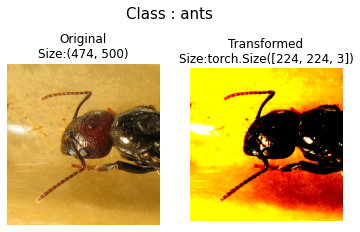

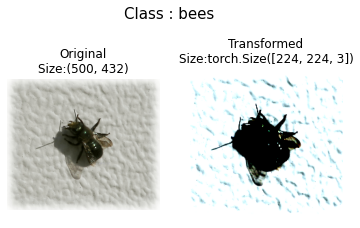

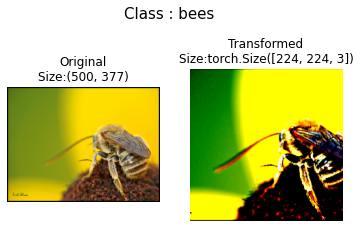

In [47]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths: 
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)
      ## transformed image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize:{transformed_image.shape}")
      ax[1].axis(False)
      fig.suptitle(f'Class : {image_path.parent.stem}',fontsize=15)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transforms['val'])

In [48]:
train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=data_transforms['train'])

val_dataset = datasets.ImageFolder(root=val_dir,
                                     transform=data_transforms['val'])

In [49]:
len(train_dataset),len(val_dataset)

(244, 153)

In [50]:
class_names = train_dataset.classes
class_names

['ants', 'bees']

In [51]:
img,label = train_dataset[0]

Text(0.5, 1.0, "the label of this image is ants and it's shape is torch.Size([3, 224, 224]) -> [color_channels,width,height]")

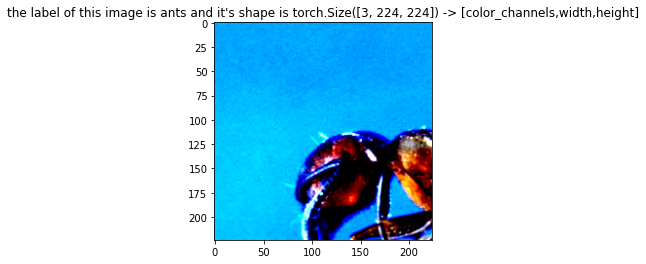

In [52]:
plt.imshow(img.permute(1,2,0))
plt.title(f"the label of this image is {class_names[label]} and it's shape is {img.shape} -> [color_channels,width,height]")

In [53]:
img, label = val_dataset[0]

Text(0.5, 1.0, "the label of this image is ants and it's shape is torch.Size([3, 224, 224]) -> [color_channels,width,height]")

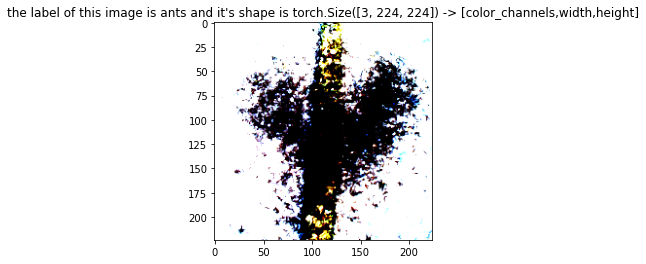

In [54]:
plt.imshow(img.permute(1,2,0))
plt.title(f"the label of this image is {class_names[label]} and it's shape is {img.shape} -> [color_channels,width,height]")

In [55]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=1)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=1)


dataloaders = {'train': DataLoader(dataset=train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=1),
               'val' : DataLoader(dataset=val_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=1)}

dataset_sizes = {'train': len(train_dataset),
                 'val' : len(val_dataset)}


In [56]:
len(train_dataloader), len(val_dataloader)

(61, 39)

In [57]:
img, label = next(iter(train_dataloader))

print(f'Image Shape: {img.shape} -> [batch_size,color_channels,height,width]')
print(f'Label Shape: {label.shape}')

Image Shape: torch.Size([4, 3, 224, 224]) -> [batch_size,color_channels,height,width]
Label Shape: torch.Size([4])


## Traing and validation loop in one function but messy

In [ ]:
import time
import copy 
from torch.optim import lr_scheduler
from torchvision import models

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.7082 Acc: 0.6475
val Loss: 0.5921 Acc: 0.7516

Epoch 1/24
----------
train Loss: 0.5687 Acc: 0.7459
val Loss: 0.2317 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3645 Acc: 0.8402
val Loss: 0.3609 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4548 Acc: 0.8607
val Loss: 0.2745 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.5213 Acc: 0.7828
val Loss: 0.2941 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.5707 Acc: 0.7705
val Loss: 0.5540 Acc: 0.8170

Epoch 6/24
----------
train Loss: 0.4760 Acc: 0.7910
val Loss: 0.3600 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.3326 Acc: 0.8566
val Loss: 0.2423 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3980 Acc: 0.8238
val Loss: 0.2261 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3877 Acc: 0.8320
val Loss: 0.2160 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2974 Acc: 0.8607
val Loss: 0.2614 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.2929 Acc: 0.8770
val Loss: 0.2059 Acc: 0.9216

Ep

## Refactored training and validation loops

In [58]:
# This function is the training function of a model : training time
from torch import nn
def train_loop(model : nn.Module,
          optimizer : torch.optim.Optimizer,
          train_dataloader : DataLoader,
          loss_fn : nn.Module,
          scheduler : torch.optim.lr_scheduler,
          device = device):
  model.train()
  accuracy = 0
  train_loss = 0
  for batch,(X,y) in enumerate(train_dataloader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item() 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _ , y_pred_class = torch.max(y_pred,1)
    accuracy += (y == y_pred_class).sum().item()/len(y_pred)

  scheduler.step()
  train_loss = train_loss/len(train_dataloader)
  accuracy = accuracy /len(train_dataloader)


  return accuracy, train_loss

In [59]:
#This function is the validation function : inference time 
def validation_loop(model : nn.Module,
                    optimizer : torch.optim.Optimizer,
                    val_dataloader : DataLoader,
                    loss_fn : nn.Module,
                    device = device):
  model.eval()
  accuracy = 0 
  val_loss = 0 
  with torch.inference_mode():
    for batch, (X,y) in enumerate(val_dataloader):
      X,y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred,y)
      val_loss += loss.item() 
      _ , y_pred_class = torch.max(y_pred,1)
      accuracy += (y_pred_class==y).sum()/len(y_pred_class)
  
  val_loss = val_loss / len(val_dataloader)
  accuracy = accuracy / len(val_dataloader)
  return accuracy, val_loss
  


In [60]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import copy
from tqdm import tqdm
# This is training + inference
def train(model : nn.Module,
          train_dataloader : torch.utils.data.DataLoader,
          val_dataloader : torch.utils.data.DataLoader,
          num_epochs : int,
          optimizer : torch.optim.Optimizer,
          loss_fn : nn.Module,
          scheduler : torch.optim.lr_scheduler,
          device = device):
  results = {
      "train_acc" : [],
      "train_loss" : [], 
      "val_acc" : [],
      "val_loss": []
  }

  best_model_weights = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in tqdm(range(num_epochs)):
    train_acc,train_loss = train_loop(model=model,
                                      optimizer=optimizer,
                                      train_dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      scheduler=scheduler,
                                      device = device)
    
    val_acc, val_loss = validation_loop(model=model,
                                        optimizer=optimizer,
                                        val_dataloader=val_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)  
    print(f"\nEpoch {epoch+1}:")
    print(f"\nTrain accuracy : {train_acc : .4f} | Training loss : {train_loss : .4f}")
    print(f"validation accuracy : {val_acc : .4f} | validation loss : {val_loss : .4f} ")
    print('-'*100)
    results["train_acc"].append(train_acc)
    results["train_loss"].append(train_loss)
    results["val_acc"].append(val_acc)
    results["val_loss"].append(val_loss)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_weights = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_weights)
  print(f"Best validation accuracy : { best_acc : .4f}")

  return model
    


In [62]:
# Transfer learning part : finetuning the model 
# Load a pretrained model and reset final fully connected layer.

from timeit import default_timer as timer
from torch.optim import lr_scheduler
from torchvision import models


NUM_EPOCHS = 25

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features 
model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(),lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

start = timer()
model_ft = train(model=model_ft,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 optimizer=optimizer,
                 scheduler=exp_lr_scheduler,
                 loss_fn= criterion,
                 num_epochs=NUM_EPOCHS,
                 device=device)

end = timer()

print(f"training time {end - start : .4f}")




/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  4%|▍         | 1/25 [00:04<01:42,  4.25s/it]


Epoch 1:

Train accuracy :  0.6025 | Training loss :  0.6473
validation accuracy :  0.8269 | validation loss :  0.4550 
----------------------------------------------------------------------------------------------------


  8%|▊         | 2/25 [00:08<01:35,  4.16s/it]


Epoch 2:

Train accuracy :  0.7869 | Training loss :  0.4959
validation accuracy :  0.8974 | validation loss :  0.3607 
----------------------------------------------------------------------------------------------------


 12%|█▏        | 3/25 [00:15<01:58,  5.38s/it]


Epoch 3:

Train accuracy :  0.7910 | Training loss :  0.4688
validation accuracy :  0.9167 | validation loss :  0.2814 
----------------------------------------------------------------------------------------------------


 16%|█▌        | 4/25 [00:22<02:11,  6.28s/it]


Epoch 4:

Train accuracy :  0.8238 | Training loss :  0.4268
validation accuracy :  0.9359 | validation loss :  0.2349 
----------------------------------------------------------------------------------------------------


 20%|██        | 5/25 [00:30<02:18,  6.92s/it]


Epoch 5:

Train accuracy :  0.8156 | Training loss :  0.4180
validation accuracy :  0.9551 | validation loss :  0.2162 
----------------------------------------------------------------------------------------------------


 24%|██▍       | 6/25 [00:37<02:08,  6.78s/it]


Epoch 6:

Train accuracy :  0.8648 | Training loss :  0.3328
validation accuracy :  0.9295 | validation loss :  0.2073 
----------------------------------------------------------------------------------------------------


 28%|██▊       | 7/25 [00:48<02:25,  8.11s/it]


Epoch 7:

Train accuracy :  0.8074 | Training loss :  0.4228
validation accuracy :  0.9423 | validation loss :  0.1929 
----------------------------------------------------------------------------------------------------


 32%|███▏      | 8/25 [00:56<02:17,  8.11s/it]


Epoch 8:

Train accuracy :  0.8730 | Training loss :  0.3337
validation accuracy :  0.9487 | validation loss :  0.1929 
----------------------------------------------------------------------------------------------------


 36%|███▌      | 9/25 [01:00<01:47,  6.74s/it]


Epoch 9:

Train accuracy :  0.8320 | Training loss :  0.3701
validation accuracy :  0.9359 | validation loss :  0.2012 
----------------------------------------------------------------------------------------------------


 40%|████      | 10/25 [01:03<01:27,  5.81s/it]


Epoch 10:

Train accuracy :  0.8238 | Training loss :  0.3863
validation accuracy :  0.9551 | validation loss :  0.1824 
----------------------------------------------------------------------------------------------------


 44%|████▍     | 11/25 [01:09<01:19,  5.64s/it]


Epoch 11:

Train accuracy :  0.8811 | Training loss :  0.3553
validation accuracy :  0.9423 | validation loss :  0.1846 
----------------------------------------------------------------------------------------------------


 48%|████▊     | 12/25 [01:12<01:05,  5.07s/it]


Epoch 12:

Train accuracy :  0.8156 | Training loss :  0.4029
validation accuracy :  0.9487 | validation loss :  0.1965 
----------------------------------------------------------------------------------------------------


 52%|█████▏    | 13/25 [01:16<00:55,  4.67s/it]


Epoch 13:

Train accuracy :  0.8402 | Training loss :  0.3585
validation accuracy :  0.9423 | validation loss :  0.1901 
----------------------------------------------------------------------------------------------------


 56%|█████▌    | 14/25 [01:21<00:51,  4.67s/it]


Epoch 14:

Train accuracy :  0.8607 | Training loss :  0.3444
validation accuracy :  0.9423 | validation loss :  0.1897 
----------------------------------------------------------------------------------------------------


 60%|██████    | 15/25 [01:25<00:45,  4.56s/it]


Epoch 15:

Train accuracy :  0.8074 | Training loss :  0.4007
validation accuracy :  0.9551 | validation loss :  0.1836 
----------------------------------------------------------------------------------------------------


 64%|██████▍   | 16/25 [01:29<00:38,  4.29s/it]


Epoch 16:

Train accuracy :  0.8197 | Training loss :  0.3850
validation accuracy :  0.9423 | validation loss :  0.1859 
----------------------------------------------------------------------------------------------------


 68%|██████▊   | 17/25 [01:33<00:33,  4.21s/it]


Epoch 17:

Train accuracy :  0.8770 | Training loss :  0.3260
validation accuracy :  0.9487 | validation loss :  0.1843 
----------------------------------------------------------------------------------------------------


 72%|███████▏  | 18/25 [01:38<00:31,  4.47s/it]


Epoch 18:

Train accuracy :  0.7910 | Training loss :  0.3967
validation accuracy :  0.9423 | validation loss :  0.1873 
----------------------------------------------------------------------------------------------------


 76%|███████▌  | 19/25 [01:42<00:25,  4.27s/it]


Epoch 19:

Train accuracy :  0.8525 | Training loss :  0.3377
validation accuracy :  0.9551 | validation loss :  0.1775 
----------------------------------------------------------------------------------------------------


 80%|████████  | 20/25 [01:45<00:20,  4.12s/it]


Epoch 20:

Train accuracy :  0.8689 | Training loss :  0.3025
validation accuracy :  0.9359 | validation loss :  0.1946 
----------------------------------------------------------------------------------------------------


 84%|████████▍ | 21/25 [01:51<00:18,  4.51s/it]


Epoch 21:

Train accuracy :  0.9057 | Training loss :  0.3060
validation accuracy :  0.9551 | validation loss :  0.1752 
----------------------------------------------------------------------------------------------------


 88%|████████▊ | 22/25 [01:55<00:12,  4.29s/it]


Epoch 22:

Train accuracy :  0.8934 | Training loss :  0.3084
validation accuracy :  0.9359 | validation loss :  0.1911 
----------------------------------------------------------------------------------------------------


 92%|█████████▏| 23/25 [01:58<00:08,  4.14s/it]


Epoch 23:

Train accuracy :  0.8893 | Training loss :  0.2666
validation accuracy :  0.9359 | validation loss :  0.1949 
----------------------------------------------------------------------------------------------------


 96%|█████████▌| 24/25 [02:04<00:04,  4.64s/it]


Epoch 24:

Train accuracy :  0.8402 | Training loss :  0.3668
validation accuracy :  0.9423 | validation loss :  0.1839 
----------------------------------------------------------------------------------------------------


100%|██████████| 25/25 [02:08<00:00,  5.15s/it]


Epoch 25:

Train accuracy :  0.9016 | Training loss :  0.3102
validation accuracy :  0.9423 | validation loss :  0.1818 
----------------------------------------------------------------------------------------------------
Best validation accuracy :  0.9551
training time  128.6824


In [111]:
# ConvNet as fixed feature extractor
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default 
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv.parameters(),lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

start = timer()
model_conv = train(model=model_conv,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 optimizer=optimizer,
                 scheduler=exp_lr_scheduler,
                 loss_fn= criterion,
                 num_epochs=NUM_EPOCHS,
                 device=device)

end = timer()

print(f"training time {end - start : .4f}")


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  4%|▍         | 1/25 [00:04<01:43,  4.33s/it]


Epoch 1:

Train accuracy :  0.6107 | Training loss :  0.6658
validation accuracy :  0.7628 | validation loss :  0.5480 
----------------------------------------------------------------------------------------------------


  8%|▊         | 2/25 [00:08<01:31,  3.99s/it]


Epoch 2:

Train accuracy :  0.6721 | Training loss :  0.6273
validation accuracy :  0.8333 | validation loss :  0.4768 
----------------------------------------------------------------------------------------------------


 12%|█▏        | 3/25 [00:11<01:26,  3.95s/it]


Epoch 3:

Train accuracy :  0.7623 | Training loss :  0.5171
validation accuracy :  0.8141 | validation loss :  0.4374 
----------------------------------------------------------------------------------------------------


 16%|█▌        | 4/25 [00:17<01:33,  4.44s/it]


Epoch 4:

Train accuracy :  0.7828 | Training loss :  0.4754
validation accuracy :  0.9167 | validation loss :  0.3381 
----------------------------------------------------------------------------------------------------


 20%|██        | 5/25 [00:20<01:23,  4.17s/it]


Epoch 5:

Train accuracy :  0.7623 | Training loss :  0.5079
validation accuracy :  0.9295 | validation loss :  0.3134 
----------------------------------------------------------------------------------------------------


 24%|██▍       | 6/25 [00:24<01:16,  4.03s/it]


Epoch 6:

Train accuracy :  0.7869 | Training loss :  0.4529
validation accuracy :  0.9359 | validation loss :  0.3009 
----------------------------------------------------------------------------------------------------


 28%|██▊       | 7/25 [00:29<01:19,  4.42s/it]


Epoch 7:

Train accuracy :  0.7910 | Training loss :  0.4347
validation accuracy :  0.9295 | validation loss :  0.2994 
----------------------------------------------------------------------------------------------------


 32%|███▏      | 8/25 [00:33<01:11,  4.23s/it]


Epoch 8:

Train accuracy :  0.7910 | Training loss :  0.4451
validation accuracy :  0.9359 | validation loss :  0.2584 
----------------------------------------------------------------------------------------------------


 36%|███▌      | 9/25 [00:37<01:04,  4.05s/it]


Epoch 9:

Train accuracy :  0.8484 | Training loss :  0.4104
validation accuracy :  0.9423 | validation loss :  0.2697 
----------------------------------------------------------------------------------------------------


 40%|████      | 10/25 [00:41<01:00,  4.06s/it]


Epoch 10:

Train accuracy :  0.7992 | Training loss :  0.4159
validation accuracy :  0.9359 | validation loss :  0.2761 
----------------------------------------------------------------------------------------------------


 44%|████▍     | 11/25 [00:46<01:01,  4.40s/it]


Epoch 11:

Train accuracy :  0.7992 | Training loss :  0.4244
validation accuracy :  0.9551 | validation loss :  0.2652 
----------------------------------------------------------------------------------------------------


 48%|████▊     | 12/25 [00:50<00:54,  4.20s/it]


Epoch 12:

Train accuracy :  0.8238 | Training loss :  0.3846
validation accuracy :  0.9359 | validation loss :  0.2704 
----------------------------------------------------------------------------------------------------


 52%|█████▏    | 13/25 [00:54<00:48,  4.06s/it]


Epoch 13:

Train accuracy :  0.8484 | Training loss :  0.3771
validation accuracy :  0.9359 | validation loss :  0.2594 
----------------------------------------------------------------------------------------------------


 56%|█████▌    | 14/25 [01:00<00:51,  4.73s/it]


Epoch 14:

Train accuracy :  0.7992 | Training loss :  0.4232
validation accuracy :  0.9423 | validation loss :  0.2640 
----------------------------------------------------------------------------------------------------


 60%|██████    | 15/25 [01:04<00:44,  4.41s/it]


Epoch 15:

Train accuracy :  0.8484 | Training loss :  0.3890
validation accuracy :  0.9487 | validation loss :  0.2627 
----------------------------------------------------------------------------------------------------


 64%|██████▍   | 16/25 [01:07<00:37,  4.20s/it]


Epoch 16:

Train accuracy :  0.8238 | Training loss :  0.4166
validation accuracy :  0.9423 | validation loss :  0.2557 
----------------------------------------------------------------------------------------------------


 68%|██████▊   | 17/25 [01:12<00:35,  4.45s/it]


Epoch 17:

Train accuracy :  0.8033 | Training loss :  0.4290
validation accuracy :  0.9487 | validation loss :  0.2526 
----------------------------------------------------------------------------------------------------


 72%|███████▏  | 18/25 [01:16<00:30,  4.36s/it]


Epoch 18:

Train accuracy :  0.8156 | Training loss :  0.4123
validation accuracy :  0.9423 | validation loss :  0.2613 
----------------------------------------------------------------------------------------------------


 76%|███████▌  | 19/25 [01:20<00:24,  4.15s/it]


Epoch 19:

Train accuracy :  0.8156 | Training loss :  0.4140
validation accuracy :  0.9295 | validation loss :  0.2785 
----------------------------------------------------------------------------------------------------


 80%|████████  | 20/25 [01:24<00:20,  4.07s/it]


Epoch 20:

Train accuracy :  0.8525 | Training loss :  0.3940
validation accuracy :  0.9359 | validation loss :  0.2496 
----------------------------------------------------------------------------------------------------


 84%|████████▍ | 21/25 [01:29<00:17,  4.46s/it]


Epoch 21:

Train accuracy :  0.7910 | Training loss :  0.4251
validation accuracy :  0.9487 | validation loss :  0.2552 
----------------------------------------------------------------------------------------------------


 88%|████████▊ | 22/25 [01:33<00:12,  4.25s/it]


Epoch 22:

Train accuracy :  0.8033 | Training loss :  0.4130
validation accuracy :  0.9423 | validation loss :  0.2881 
----------------------------------------------------------------------------------------------------


 92%|█████████▏| 23/25 [01:37<00:08,  4.08s/it]


Epoch 23:

Train accuracy :  0.8730 | Training loss :  0.3760
validation accuracy :  0.9423 | validation loss :  0.2680 
----------------------------------------------------------------------------------------------------


 96%|█████████▌| 24/25 [01:42<00:04,  4.42s/it]


Epoch 24:

Train accuracy :  0.8525 | Training loss :  0.3741
validation accuracy :  0.9359 | validation loss :  0.2559 
----------------------------------------------------------------------------------------------------


100%|██████████| 25/25 [01:46<00:00,  4.25s/it]


Epoch 25:

Train accuracy :  0.8566 | Training loss :  0.3941
validation accuracy :  0.9359 | validation loss :  0.2742 
----------------------------------------------------------------------------------------------------
Best validation accuracy :  0.9551
training time  106.2567



## Visualize 



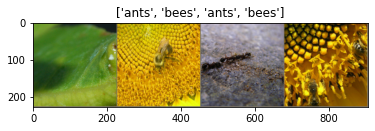

In [63]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [64]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [109]:
import random 
import math
def predict_visualize(model : nn.Module ,k : int = 6, nrows : int = 2 , ncols : int = 3):
  plt.figure(figsize=(15,10))
  for i,(sample, y) in enumerate(random.sample(list(val_dataset),k=k)):
    pred_logit = model(sample.to(device).unsqueeze(0))
    _ , pred = torch.max(pred_logit,1)

    plt.subplot(nrows,ncols,i+1)
    plt.imshow(sample.permute(1,2,0).numpy().astype("uint8"))
    truth_label = class_names[y]
    pred_label = class_names[pred.cpu()]
    title_text = f"Truth : {truth_label} | Pred : {pred_label}"
    if truth_label == pred_label: 
      plt.title(title_text,fontsize=10,c='g')
    else: 
      plt.title(title_text,fontsize=10,c='r')
    plt.axis(False)

  

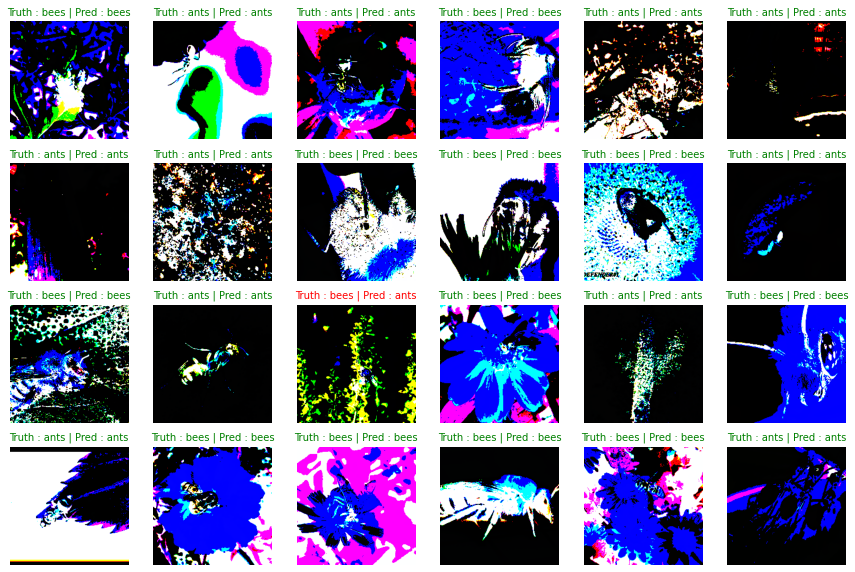

In [110]:
predict_visualize(k=24,nrows=4,ncols=6,model=model_ft)